In [1]:
import re
import os
import sys
import cv2
import math
import time
import shutil

import pandas as pd
import numpy as np
import pydicom
from utils import *

import matplotlib.pyplot as plt
from tqdm import tqdm
from shutil import copy
from datetime import date
from pydicom.uid import UID, generate_uid
from multiprocessing import dummy as multiprocessing

# ROI dcm to png frame
- method
    1. dcm header 정보를 이용하여 crop
    2. cv2 method를 이용하여 한번더 crop

- version_1에서 동일한 영역이 없어서 제외한 case
    - study_id : 61398238_4, 61398238_7

In [4]:
TS_df = pd.read_excel('/home/work/LUS/Dataset/csv_files/Tempollary_Separated_Label.xlsx', index_col=False)

In [5]:
print(len(TS_df))

TS_df.head()

56


,Patient \nnumber,PatientID,Data_idx,StudyDate,Data_type,Point Zone,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score Leader,Lung Ultrasound Score Final
0,1,44937986,2,20240712,video,NaN,1_152,NaN,NaN,NaN,NaN,1,0,NaN
1,1,44937986,3,20240712,video,NaN,NaN,NaN,NaN,"1_49, 75_124","1_41, 79_119",0,3ce,NaN
2,1,44937986,4,20240712,video,NaN,NaN,NaN,NaN,"1_24, 44_100, 121_150","1_19, 51_96, 131_148",0,3ce,NaN
3,1,44937986,5,20240712,video,NaN,"38_45, 119_124","7_37, 80_114","47_59, 127_137",NaN,NaN,1,2,NaN
4,1,44937986,6,20240712,video,NaN,76_88,"41_61, 132_137","10_22, 66_72, 90_101, 147_151",NaN,NaN,1,2,NaN


In [11]:
def create_path(row):
    root_path = "/home/work/LUS/Dataset/processed_temporally_separated_dataset_dcm"
    patient_id = int(row['PatientID'])
    data_idx = f"{row['Data_idx']:05d}"
    return f"{root_path}/{patient_id}/{data_idx}.dcm"

In [12]:
TS_df['dcm_path'] = TS_df.apply(create_path, axis=1)

print(TS_df.iloc[0]['dcm_path'])

/home/work/LUS/Dataset/processed_temporally_separated_dataset_dcm/44937986/00002.dcm


In [13]:
TS_df.head()

,Patient \nnumber,PatientID,Data_idx,StudyDate,Data_type,Point Zone,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score Leader,Lung Ultrasound Score Final,dcm_path
0,1,44937986,2,20240712,video,NaN,1_152,NaN,NaN,NaN,NaN,1,0,NaN,/home/work/LUS/Dataset/processed_temporally_se...
1,1,44937986,3,20240712,video,NaN,NaN,NaN,NaN,"1_49, 75_124","1_41, 79_119",0,3ce,NaN,/home/work/LUS/Dataset/processed_temporally_se...
2,1,44937986,4,20240712,video,NaN,NaN,NaN,NaN,"1_24, 44_100, 121_150","1_19, 51_96, 131_148",0,3ce,NaN,/home/work/LUS/Dataset/processed_temporally_se...
3,1,44937986,5,20240712,video,NaN,"38_45, 119_124","7_37, 80_114","47_59, 127_137",NaN,NaN,1,2,NaN,/home/work/LUS/Dataset/processed_temporally_se...
4,1,44937986,6,20240712,video,NaN,76_88,"41_61, 132_137","10_22, 66_72, 90_101, 147_151",NaN,NaN,1,2,NaN,/home/work/LUS/Dataset/processed_temporally_se...


In [14]:
video_path = TS_df['dcm_path'].iloc[10]
# video_path = v1_video_df['dcm_path'].iloc[30]
dataset = pydicom.dcmread(video_path, force=True)
if dataset.PixelData:
    test_arr = dataset.pixel_array

    # get information to crop each frame
    xmin = dataset[(0x018, 0x6011)].value[0][(0x018, 0x6018)].value
    ymin = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601a)].value
    xmax = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601c)].value
    ymax = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601e)].value

    frames, height, width, channels = test_arr.shape
    cropped_height = ymax - ymin
    cropped_width = xmax - xmin

    final_video = np.zeros((frames, cropped_height, cropped_width, 3), dtype=np.uint8)
    for i in range(frames):
        output = test_arr[i, :, :, 0]

        # crop image
        cropped_frame = output[ymin:ymax, xmin:xmax]

        # Convert to 3-channel image
        final_output = cv2.merge([cropped_frame, cropped_frame, cropped_frame])
        
        final_video[i] = final_output
        
print(final_video.shape)

(152, 771, 988, 3)


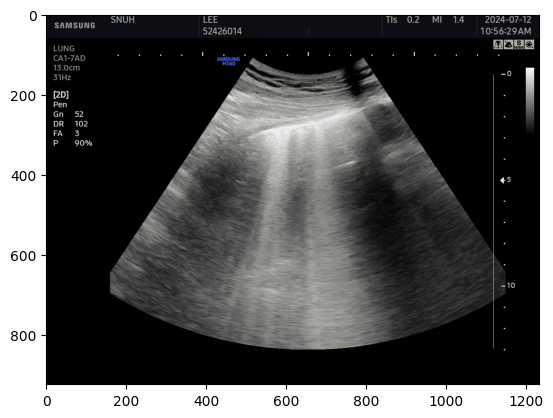

In [15]:
plt.imshow(test_arr[150])

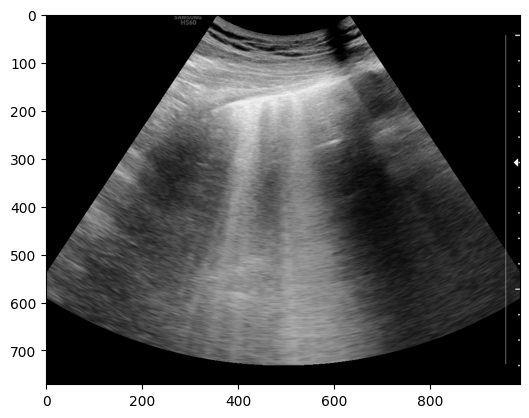

In [16]:
plt.imshow(final_video[150])

160 109 989 729
Top Left: (160, 109)
Top Right: (1149, 109)
Bottom Left: (160, 838)
Bottom Right: (1149, 838)


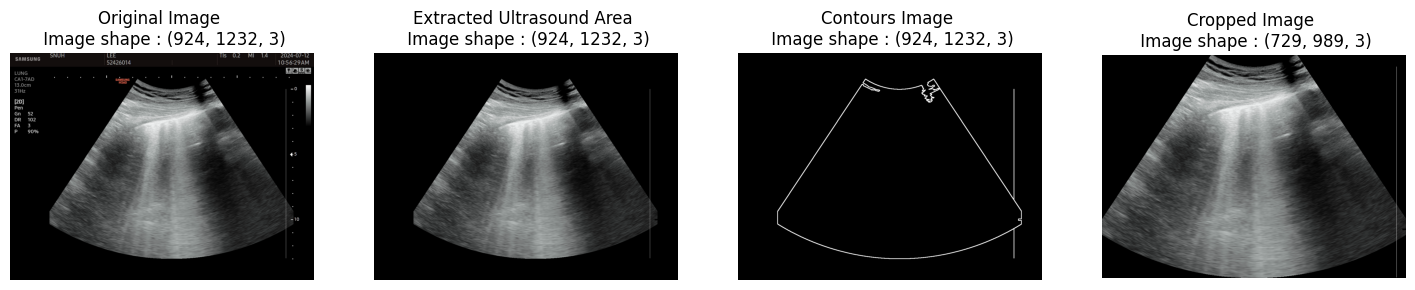

In [11]:
'''# ex_img = final_video[150]
ex_img = test_arr[150]
rgb_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB)

# 그레이스케일로 변환
gray = cv2.cvtColor(ex_img, cv2.COLOR_BGR2GRAY)

# 임계값을 적용하여 초음파 영역을 분리
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

# 컨투어 찾기
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # 가장 큰 컨투어 선택
    largest_contour = max(contours, key=cv2.contourArea)

    # 빈 마스크 생성
    mask = np.zeros_like(gray)

    # 마스크에 초음파 스캔 영역을 채우기
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # 원본 이미지에서 마스크된 영역만 추출
    result = cv2.bitwise_and(ex_img, ex_img, mask=mask)

    # 컨투어의 경계 사각형 구하기
    x, y, w, h = cv2.boundingRect(largest_contour)
    print(x, y, w, h)
    top_left = (x, y)
    top_right = (x + w, y)
    bottom_left = (x, y + h)
    bottom_right = (x + w, y + h)

    # 네 점 출력
    print(f"Top Left: {top_left}")
    print(f"Top Right: {top_right}")
    print(f"Bottom Left: {bottom_left}")
    print(f"Bottom Right: {bottom_right}")
    # 이미지 크롭
    cropped_img = result[y:y+h, x:x+w]

    # 빈 이미지에 컨투어 그리기
    contour_img = np.zeros_like(ex_img)
    cv2.drawContours(contour_img, [largest_contour], -1, (255, 255, 255), thickness=2)  # 흰색 컨투어

    # 결과 출력
    fig, ax = plt.subplots(1, 4, figsize=(18, 6))

    # 원본 이미지 출력
    ax[0].imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original Image \n Image shape : {ex_img.shape}")
    ax[0].axis('off')

    # 초음파 영역 추출된 이미지 출력
    ax[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Extracted Ultrasound Area \n Image shape : {result.shape}")
    ax[1].axis('off')

    # 컨투어 이미지 출력
    ax[2].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title(f"Contours Image \n Image shape : {contour_img.shape}")
    ax[2].axis('off')

    # 크롭된 이미지 출력
    ax[3].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    ax[3].set_title(f"Cropped Image \n Image shape : {cropped_img.shape}")
    ax[3].axis('off')

    # 플롯 표시
    plt.show()
else:
    print("No contours found in the image.")'''

In [10]:
cropped_img.shape

(729, 989, 3)

# SNUH_MICU crop point
- (x, y, w, h) = (160 109 989 729)
- Top Left: (160, 109)
- Top Right: (1149, 109)
- Bottom Left: (160, 838)
- Bottom Right: (1149, 838)

In [13]:
a, b, c, d = 1, 2, 3, 4
print(a, b, c, d)

1 2 3 4


In [17]:
def dcm_frames_to_png(video_path, destinationFolder, folder_name, file_name, convert_type):
    # fileName = dicom_path.split('/')[-1]

    dataset = pydicom.dcmread(video_path, force=True)
    if dataset.PixelData:
        test_arr = dataset.pixel_array
        
        # 동영상인 case
        if len(test_arr.shape) == 4:  

            # get information to crop each frame
            xmin = dataset[(0x018, 0x6011)].value[0][(0x018, 0x6018)].value
            ymin = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601a)].value
            xmax = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601c)].value
            ymax = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601e)].value

            frames, height, width, channels = test_arr.shape
            cropped_height = ymax - ymin
            cropped_width = xmax - xmin

            try:
                fps = dataset[(0x18, 0x40)].value
            except:
                print("couldn't find frame rate, default to 30")
                fps = 30

            if convert_type == 'ALL':
                for i in range(frames):
                    output = test_arr[i, :, :, 0]

                    # crop image
                    cropped_frame = output[ymin:ymax, xmin:xmax]

                    # Convert to 3-channel image
                    final_output = cv2.merge([cropped_frame, cropped_frame, cropped_frame])

                    # Save each frame as PNG
                    png_filename = os.path.join(destinationFolder, folder_name, f"{folder_name}_{file_name.replace('.dcm', '')}_{i+1}.png")
                    cv2.imwrite(png_filename, final_output)

#                 print(f'Frames saved as PNG files in {png_filename}')
                
#             elif convert_type == 'ROI':    
                
#                 for i in range(start_frame-1, end_frame):
#                     output = test_arr[i, :, :, 0]

#                     # crop image
#                     cropped_frame = output[ymin:ymax, xmin:xmax]

#                     # Convert to 3-channel image
#                     final_output = cv2.merge([cropped_frame, cropped_frame, cropped_frame])

#                     # Save each frame as PNG
#                     png_filename = os.path.join(destinationFolder, folder_name, f"{folder_name}_{file_name.replace('.dcm', '')}_{i+1}.png")
#                     cv2.imwrite(png_filename, final_output)

#                 print(f'Frames saved as PNG files in {destinationFolder}')
        
        # image case
        elif len(test_arr.shape) == 3:
            
            # get ionformation to crop each frame
            xmin = dataset[(0x018, 0x6011)].value[0][(0x018, 0x6018)].value
            ymin = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601a)].value
            xmax = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601c)].value
            ymax = dataset[(0x018, 0x6011)].value[0][(0x018, 0x601e)].value
            
            height, width, channels = test_arr.shape
            cropped_height = ymax - ymin
            cropped_width = xmax - xmin
            
            # crop image
            cropped_frame = test_arr[ymin:ymax, xmin:xmax]

            # Convert to 3-channel image
#             final_output = cv2.merge([cropped_frame, cropped_frame, cropped_frame])

            # Save each frame as PNG
            png_filename = os.path.join(destinationFolder, folder_name, f"{folder_name}_{file_name.replace('.dcm', '')}.png")
            cv2.imwrite(png_filename, cropped_frame)
            print(f'Frames saved as PNG files in {destinationFolder}')
            
    else:
        print(f'{file_name} is empty.')
        return 0

In [3]:
'''def dcm_frames_to_png_v2(video_path, destinationFolder, folder_name, file_name, convert_type):
    # fileName = dicom_path.split('/')[-1]

    dataset = pydicom.dcmread(video_path, force=True)
    if dataset.PixelData:
        test_arr = dataset.pixel_array
        
        # 동영상인 case
        if len(test_arr.shape) == 4:

            frames, height, width, channels = test_arr.shape

            try:
                fps = dataset[(0x18, 0x40)].value
            except:
                print("couldn't find frame rate, default to 30")
                fps = 30

            if convert_type == 'ALL':
                for i in range(frames):
                    org_img = test_arr[i, :, :, 0]
                    
                    # snuh 기준
                    x, y, w, h = 160, 109, 989, 729
                    cropped_img = org_img[y:y+h, x:x+w]
                    
                    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_GRAY2BGR)
                    
                    # Save each frame as PNG
                    png_filename = os.path.join(destinationFolder, folder_name, f"{folder_name}_{file_name.replace('.dcm', '')}_{i+1}.png")
                    cv2.imwrite(png_filename, cropped_img)
        
        # image case
        elif len(test_arr.shape) == 3:
            
            # snuh 기준
            x, y, w, h = 160, 109, 989, 729
            cropped_img = test_arr[y:y+h, x:x+w]

            png_filename = os.path.join(destinationFolder, folder_name, f"{folder_name}_{file_name.replace('.dcm', '')}.png")
            cv2.imwrite(png_filename, cropped_img)
            print(f'Frames saved as PNG files in {destinationFolder}')
            
    else:
        print(f'{file_name} is empty.')
        return 0'''

In [20]:
pwd

'/home/work/LUS/code'

### all dcm to png frame

In [18]:
destination_folder = '/home/work/LUS/Dataset/temporally_separated_dcm_to_png'

count = 0

for idx, row in tqdm(TS_df.iterrows(), total=len(TS_df)):
    path = row.dcm_path
    folder_name = path.split('/')[-2]
    file_name = path.split('/')[-1]
        
    count += 1
    
    if not os.path.exists(os.path.join(destination_folder, folder_name, file_name)):
        os.makedirs(os.path.join(destination_folder, folder_name), exist_ok=True)
    
    # convert dcm to png
    dcm_frames_to_png(path, destination_folder, folder_name, file_name, convert_type= 'ALL')

100% 56/56 [06:18<00:00,  6.76s/it]
